In [406]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import json
import re

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [407]:
dfp = pd.read_csv('data-set/personal_valid.csv')
dfo = pd.read_csv('data-set/other_valid.csv')
dfp = dfp.rename(columns={'Unnamed: 0': 'ID'})
dfo = dfo.rename(columns={'Unnamed: 0': 'ID'})
pd.set_option('display.max_columns', 30)
df = None

## Integrácia dát a deduplikácia záznamov

Táto časť je skopírovaná z predchadzajúceho notebooku 'Prieskumná_analýza.ipynb'. Spojí dataset other a personal do jedného a následne odstráni duplikatne záznamy. 

In [408]:
# merges duplicates
def merge(name, dfo_duplicates):
    df = dfo_duplicates.loc[dfo_duplicates['name'] == name]
    return df.groupby(['name'], as_index=False).first()

def merge_other_personal(df):
    dfo_duplicates = dfo[dfo.duplicated(['name'], keep=False)]
    dfo_unique = dfo.drop_duplicates(subset=["name"], keep=False)
    merged = []

    for name in dfo_duplicates['name'].unique():
        merged.append(merge(name, dfo_duplicates))

    dfo_unique = dfo_unique.append(merged)

    x = pd.merge(dfp, dfo_unique, on='name')
    x = x.drop(columns=['address_y', 'ID_y'])
    x = x.rename(columns={"ID_x": "ID", "address_x": "address"})
    return x
    
# df = merge_other_personal(df)

Dalsia vec ktoru musime spravit, je rozbalenie medical info. Nachadza sa tu: kurtosis_oxygen, mean_oxygen, skewness_oxygen a std_oxygen. Tieto hodnoty su ulozene ako object (string), pre to ich budeme musiet previest na cislo.

In [409]:
def unpack_medical(df):
    x = df.copy()
    for i, row in x.iterrows():
        if not pd.isnull(x.at[i, 'medical_info']):
            x.at[i, 'medical_info'] = json.loads(x["medical_info"][i].replace("\'", "\""))
    # vytvorenie stlpcov z medical_info a ich spojenie so zvyskom dataframe
    df_med_info = x["medical_info"].apply(pd.Series)
    df_med_info = df_med_info.drop(0, 1)
    x = pd.concat([x, df_med_info], axis = 1).drop("medical_info", axis = 1)
    return x

# df = unpack_medical(df)

Zmena kurtosis_oxygen, mean_oxygen, skewness_oxygen, std_oxygen z object na float

In [410]:
def obj_to_float(df):
    x = df.copy()
    # kurtosis_oxygen
    x['kurtosis_oxygen'] = x['kurtosis_oxygen'].astype(np.float)
    # mean_oxygen
    x['mean_oxygen'] = x['mean_oxygen'].astype(np.float)
    # skewness_oxygen
    x['skewness_oxygen'] = x['skewness_oxygen'].astype(np.float)
    # std_oxygen
    x['std_oxygen'] = x['std_oxygen'].astype(np.float)
    return x
# df = obj_to_float(df)

Rozhodli sme sa dropnut niektore stlpce. Meno, ID, fnlwgt. Dovodom je, ze kazda z tychto hodnot je rozna a na vyskyt cukrovky nema vplyv.  
Mame 2 udaje ktore nam ukazuju vek cloveka - age a date_of_birth. Kedze nemame ziadne nullove hodnoty pri age, nemusime podla datumu narodenia vek urcovat. Datum narodenia teda mozeme vyhodit

In [411]:
def remove_unimportant_columns(df):
    x = df.copy()
    x = x.drop(['ID', 'name', 'fnlwgt', 'date_of_birth'], axis=1)
    return x
# df = remove_unimportant_columns(df)

Odstranenie space-ov z nazvov atributov

In [412]:
def remove_space(df):
    x = df.copy()
    x = df.apply(lambda y: y.str.strip() if y.dtype == "object" else y)
    return x

# df = remove_space(df)

Nahradenie hodnot, ktore mozu nadobudat len 2 stavy

In [413]:
def put_0_1_values(df):
    x = df.copy()
    
    # pohlavia: Male -> 1; Female -> 0
    x['sex'] = x['sex'].replace('Male', 1)
    x['sex'] = x['sex'].replace('Female', 0)
    
    # tehotnost: T -> 1; F -> 0
    x['pregnant'] = x['pregnant'].replace(regex='(?i)f.*', value=0)
    x['pregnant'] = x['pregnant'].replace(regex='(?i)t.*', value=1)
    
    # muzi oznaceni ako tehotny su prepisani na 0
    x.loc[(x['pregnant'] == 1) & (x['sex'] == 1), 'pregnant'] = 0
    
    # zmena income hodnot: <=50K -> 0; >50K -> 1
    x['income'] = x['income'].replace('<=50K', 0)
    x['income'] = x['income'].replace('>50K', 1)
    
    # zmena nazvov stlpcov na presnejsie
    x = x.rename(columns={"pregnant": "is_pregnant", "income": "income_>50K"})
    
    return x

# df = put_0_1_values(df)

**Education a education-num**  
Zistujeme, co znamena education a education num. Predpoklad je, ze education-num je numericka reprezentacia education

In [414]:
def education_analysis(df):
    # prints unique values in education
    x = df.copy()
    unique_edu = pd.unique(x['education'])
    print("Pred zjednotenim:\n", unique_edu)
    
    # Zjednotenie reprezentacii
    x['education'] = x['education'].replace(regex='(?i)_', value='-')
    unique_edu = pd.unique(x['education'])
    print("\nPo zjednoteni:\n", unique_edu)
    
    # hodnoty v education-num a v education
    print("\nHodnoty v jednotlivych education:")
    for item in unique_edu:
        edu_num = x.query("education == @item")["education-num"].unique()
        print(item, edu_num)

# education_analysis(df)

Vidime ze education-num je ciselna reprezentacia education. Vytvorime si dictionary, ktory bude priradovat education ku education-num, s tym ze nechame celociselne reprezentacie od 1 po 16.

In [415]:
#vrati unikatne hodnoty v stlpci education
def get_unique_edu(df):
    x = df.copy()
    x['education'] = x['education'].replace(regex='(?i)_', value='-')
    unique_edu = pd.unique(x['education'])
    return unique_edu

# rozne hodnoty education-num pre unikatny education zmeni na jedno (napr.: 5th-6th [  3. 300.] -> 3)
def get_edu_num(edu_num):
    for num in edu_num:
        if num is None:
            continue
        elif num < 100:
            return int(num)

def transform_education(df):
    x = df.copy()
    edu_to_num = {}
    #vytvorenie dictionary s moznymi hodnotami v jendotlivych education values
    for item in get_unique_edu(x):
        edu_num = x.query("education == @item")["education-num"].unique()
        edu_to_num[item] = get_edu_num(edu_num)
    
    # zmena moznych hodnot v education na rovnake
    x['education'] = x['education'].replace(regex='(?i)_', value='-')

    # namapuje nazvy education na cisla z dictionary
    x["education"] = x["education"].map(edu_to_num)
    
    # Dropne nepotrebny column education-num (bol nahradeny)
    x = x.drop(['education-num'], axis=1)
    return x
    
# df = transform_education(df)

Cele adresy nam netreba pretoze 

In [416]:
def find_state(address):
    i = re.search('\x5cn.+\D', address)
    return address[i.start():i.end()][-3:-1]
    #return address[-8:][:2]

def address_to_state(df):
    x = df.copy()
    x['address'] = x['address'].apply(find_state)
    x = x.rename(columns={"address": "state"})
    return x

# df = address_to_state(df)

Otazniky zmenime na NaN 

In [417]:
def replace_with_nan(df):
    x = df.copy()
    x = x.replace(['??', '?'], np.nan)
    return x
# df = replace_with_nan(df)

Zjednotime hodnoty vo workclass (local-gov a Local-gov)

In [418]:
def transform_workclass(df):
    x = df.copy()
    x['workclass'] = x['workclass'].str.lower()
    return x
# df = transform_workclass(df)

Funkcia spajajuca integraciu dat do jednej. Integraciu tvori spojenie dataframov other a personal, deduplikacia zaznamov, zjednotenie interpretacii hodnot a zbavenie sa nepotrebnych stlpcov, pripadne ponechanie casti hodnoty v stlpci.

In [419]:
def integration_combined(df):
#     df = df.copy()
    # merges other and personal df
    df = merge_other_personal(df)
    # upacks medical info into columns
    df = unpack_medical(df)
    # changes objects unpacked in medical info (odfygen) to float
    df = obj_to_float(df)

    # remove unimportant columns like name or fnlwgt
    df = remove_unimportant_columns(df)
    # removes spaces at the start of values
    df = remove_space(df)
    # replace values that have only 2 options vwith 1 or 2
    df = put_0_1_values(df)
    # gets rid of education and replaces it with number from education-num
    df = transform_education(df)
    # gets rid of address and only keep state
    df = address_to_state(df)
    # replaces ? with nan
    df = replace_with_nan(df)
    # workclass values into lower case -> gets rid of duplicates
    df = transform_workclass(df)
    return df

### Zmena na ciselne hodnoty

In [420]:
def label_encode_strings(df):
    """Nahradi stringy ciselnymi hodnotami pomocou sklearn LabelEncoderu."""
    x = df.copy()
    
    enc = LabelEncoder()
    cols_to_transform = ['race', 'state', 'marital-status', 'occupation', 'relationship', 'native-country', 'workclass']
    x[cols_to_transform] = x[cols_to_transform].apply(enc.fit_transform)
    
    print("Table of mapping numeric values to cathegorical data:\n")
    for i in cols_to_transform:
        print(f'--- {i} ---')
        values = df[i].unique()
        encoded = enc.fit(values).transform(values)
        encoding = enc.inverse_transform(encoded)
        for e in range(len(encoded)):
            print(f'{encoded[e]} : {encoding[e]}')
        print('\n')
    
    return x
# label_encode_strings(df)

## Chybajuce hodnoty a outliers

### Chybajuce hodnoty

Chybajuce hodnoty doplname osobitne pre ciselne udaje a osobitne pre kategoricke udaje. Na numericke pouzivame metody median, mean a KNN. Vyber ktoru pouzijeme sa zadava v pipeline

In [421]:
def separate_by_dtype(df):
    """Rozdeli dataframe na stringy a numericke data."""
    df_num = pd.DataFrame()
    df_str = pd.DataFrame()

    for col in df:
        # Ak je to int alebo float tak sa jedna o numericke data
        if df[col].dtypes in ['float64', 'int64']:
            df_num[col] = df[col]
        else: # Inak string
            df_str[col] = df[col]
    
    return df_num, df_str

In [422]:
def replace_missing_strings(df):
        """Nahradi chybajuce stringy pomocou SimpleImputer zo sklearn.impute strategiou most_frequent."""
        x = df.copy()
        x = SimpleImputer(strategy="most_frequent").fit_transform(x)
        
        # Z novych hodnot sa vytvori dataframe
        x = pd.DataFrame(x)
        
        # Pomenujeme stlpce a riadky rovnako ako v povodnom dataframe
        x.columns = df.columns
        x.index = df.index
        
        return x

def replace_missing_numbers(df, strat='median'):
    """Nahradi chybajuce numericke data pomocou zvolenej strategie (median, mean alebo kNN)."""
    x = df.copy()
    
    # Pre zvolenu strategiu sa vytvori imputer
    if strat in ['mean', 'median']:
        imp = SimpleImputer(strategy=strat)
    else:
        imp = KNNImputer()
    
    # Doplnia sa chybajuce hodnoty
    x = imp.fit_transform(x)
    
    # Z novych hodnot sa vytvori dataframe
    x = pd.DataFrame(x)
    
    # Pomenujeme stlpce a riadky rovnako ako v povodnom dataframe
    x.columns = df.columns
    x.index = df.index
    
    x['class'] = x['class'].round()
    x['income_>50K'] = x['income_>50K'].round()
    
    return x

In [423]:
def replace_missing_values(df, strat='median'):
    df_num, df_str = separate_by_dtype(df)
    
    df_str = replace_missing_strings(df_str)
    df_num = replace_missing_numbers(df_num, strat)
    
    return pd.concat([df_str, df_num], axis=1, sort=False)

### Outliers

Outliers musime najprv identifikovat a potom spracovat: 
1. Identifikacia outlierov - Identifikacia: 3x standard deviations from the mean
2. spracovanie outlierov
    - Nahradenie outlierov s 5, 95 perscentilmi
    - Odstranenie outlierov - mame tu aj taku moznost, no zalezi na poradi v akom prechadzame. Ak by sme vyhodili cely       riadok, mohlo by nam to pokazit uz vyhodnonotene stlpce. Remove teda radsej nepouzivame

In [424]:
# # mozme pouzit po doplneni nan
# def get_binary_col(col):
#     if len(col.unique()) == 2:
#         return True    
    
    
def outliers(df, method='percentil'):
    x = df.copy()
    
    outliners_for =['skewness_glucose','mean_glucose', 'std_glucose', 'kurtosis_glucose', 
                    'skewness_oxygen', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen']
    
    for column in df.columns:
        if column in outliners_for:

            mean = x[column].mean()
            std_dev = x[column].std()
            out_95 = mean + 3 * std_dev
            out_05 = mean - 3 * std_dev

            # remove len ako test
            if (method == 'remove'):
                x.drop(x.loc[(x[column] > out_95)].index, inplace = True, axis=0)

            elif (method == 'percentil'):
                p_95 = x[column].quantile(0.95)
                p_05 = x[column].quantile(0.05)
#                 print("column: ", column, "p_95: ", p_95,"p_05: ", p_05)
#                 print(x.loc[(x[column] > out_95), column])
                x.loc[(x[column] > out_95), column] = p_95
#                 print("replaced:", x.loc[3][column])
                x.loc[(x[column] < out_05), column] = p_05
    
    x = x.reset_index(drop=True)
    return x

# print(df.loc[3]['skewness_glucose'])
# df = outliers(df, 'percentil')
# print(df.loc[3]['skewness_glucose'])


### Transformácia atribútov  
Transformaciu robime pomocou MinMaxScaler alebo PowerTransformer. Vyber sa robi v pipeline. Taktiez zobrazujeme graf vybraneho stlpca, aby sme videli akym sposobom sa nam hodnoty zmenili

In [425]:
def transform(df, method='power', plot='age'):
    x = df.copy()
    display(x) 
    plt.figure()
    sns.histplot(x[plot], kde=True, color="Green")
    
    if method == 'power':
        trans = PowerTransformer(method='yeo-johnson')
    else:
        trans = MinMaxScaler()
    
    x = trans.fit_transform(x)
    # convert the array back to a dataframe
    dataset = pd.DataFrame(x)
    X_imputed_df = pd.DataFrame(x, columns = df.columns)
    plt.figure()
    sns.histplot(X_imputed_df[plot], kde=True, color="Red")
    return X_imputed_df

# power_transform(df)
    

In [426]:
def plot_g(df):
    plt.figure()
    sns.histplot(df['age'], kde=True, color="Black")
    return df

## Znovupoužiteľnosť predspracovania - Pipeline  

Table of mapping numeric values to cathegorical data:

--- race ---
4 : White
2 : Black
1 : Asian-Pac-Islander
3 : Other
0 : Amer-Indian-Eskimo


--- state ---
13 : GA
19 : KS
1 : AE
4 : AP
29 : MT
22 : MA
0 : AA
24 : ME
48 : VA
16 : ID
43 : SC
15 : IA
26 : MN
39 : OK
42 : RI
33 : NH
9 : CT
40 : OR
11 : DE
27 : MO
25 : MI
51 : WI
50 : WA
53 : WY
30 : NC
52 : WV
37 : NY
7 : CA
45 : TN
6 : AZ
35 : NM
46 : TX
2 : AK
34 : NJ
5 : AR
20 : KY
41 : PA
17 : IL
32 : NE
36 : NV
28 : MS
44 : SD
14 : HI
12 : FL
38 : OH
49 : VT
8 : CO
47 : UT
21 : LA
23 : MD
3 : AL
18 : IN
10 : DC
31 : ND


--- marital-status ---
2 : Married-civ-spouse
0 : Divorced
6 : Widowed
4 : Never-married
5 : Separated
3 : Married-spouse-absent
1 : Married-AF-spouse


--- occupation ---
6 : Other-service
5 : Machine-op-inspct
8 : Prof-specialty
4 : Handlers-cleaners
10 : Sales
1 : Craft-repair
0 : Adm-clerical
2 : Exec-managerial
11 : Tech-support
3 : Farming-fishing
12 : Transport-moving
7 : Priv-house-serv
9 : Protective-ser

,state,race,marital-status,occupation,relationship,native-country,workclass,age,sex,is_pregnant,skewness_glucose,mean_glucose,capital-gain,kurtosis_glucose,education,class,std_glucose,income_>50K,hours-per-week,capital-loss,kurtosis_oxygen,mean_oxygen,skewness_oxygen,std_oxygen
0,13,4,2,6,0,27,2,48.0,1.0,0.0,0.400023,113.687500,0.0,0.038520,11.0,0.0,45.326894,0.0,40.0,0.0,4.642782,7.227425,21.804034,31.430288
1,19,4,0,5,3,27,2,54.0,0.0,0.0,31.250361,34.406250,0.0,5.243557,10.0,1.0,31.877558,0.0,40.0,0.0,1.731936,41.427258,2.537562,61.235473
2,1,2,6,5,4,27,2,48.0,0.0,0.0,0.377293,101.328125,0.0,0.374884,10.0,0.0,43.385465,0.0,48.0,0.0,7.134172,3.418896,58.953559,19.263642
3,4,4,4,8,1,27,2,59.0,0.0,0.0,29.156437,9.976562,0.0,5.859134,11.0,1.0,32.258590,1.0,40.0,1564.0,0.742921,68.934783,-0.089009,65.174611
4,29,4,2,4,0,27,2,36.0,1.0,0.0,-0.243264,134.835938,0.0,-0.299902,9.0,0.0,50.723635,1.0,40.0,0.0,9.078860,2.269231,89.748456,18.351895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,3,4,0,8,4,27,1,46.0,0.0,0.0,2.611897,85.828125,0.0,0.783824,13.0,0.0,35.656589,0.0,35.0,0.0,7.701320,3.136288,73.019918,17.460629
1307,45,4,4,4,3,22,2,53.0,1.0,0.0,34.021146,35.929688,0.0,5.326209,9.0,1.0,31.317723,0.0,50.0,0.0,2.669580,22.634615,6.700531,50.468320
1308,42,4,2,10,0,27,2,33.0,1.0,0.0,-0.515704,125.968750,0.0,0.106988,9.0,0.0,51.607130,1.0,40.0,0.0,9.371372,2.594482,104.136934,16.903779
1309,21,4,4,1,3,27,2,55.0,1.0,0.0,0.303495,127.250000,0.0,0.111974,7.0,1.0,45.399098,0.0,30.0,0.0,5.559185,6.393813,30.623632,33.970594


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   state             1311 non-null   float64
 1   race              1311 non-null   float64
 2   marital-status    1311 non-null   float64
 3   occupation        1311 non-null   float64
 4   relationship      1311 non-null   float64
 5   native-country    1311 non-null   float64
 6   workclass         1311 non-null   float64
 7   age               1311 non-null   float64
 8   sex               1311 non-null   float64
 9   is_pregnant       1311 non-null   float64
 10  skewness_glucose  1311 non-null   float64
 11  mean_glucose      1311 non-null   float64
 12  capital-gain      1311 non-null   float64
 13  kurtosis_glucose  1311 non-null   float64
 14  education         1311 non-null   float64
 15  class             1311 non-null   float64
 16  std_glucose       1311 non-null   float64


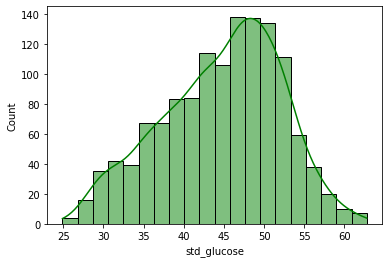

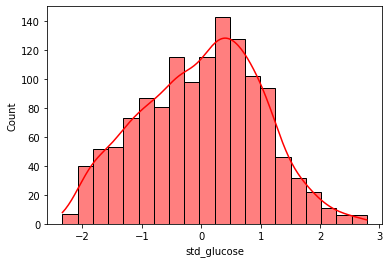

In [427]:
pipeline = Pipeline([
    ('integration', FunctionTransformer(func=integration_combined)),
    ('replace_nan', FunctionTransformer(func=replace_missing_values, kw_args={'strat': 'median'})),
    ('to_numeric', FunctionTransformer(func=label_encode_strings)),
    ('replace_outliers', FunctionTransformer(func=outliers, kw_args={'method': 'percentil'})),
    ('transform', FunctionTransformer(func=transform, kw_args={'method': 'power', 'plot': 'std_glucose'}))
])
df = pipeline.fit_transform(df)
df.info()

## Opätovná realizácia podstatných častí prieskumnej analýzy

Vidime ze uz nemame ziadne chybajuce hodnoty a vsetky stlpce su v cislenej podobe.

In [428]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   state             1311 non-null   float64
 1   race              1311 non-null   float64
 2   marital-status    1311 non-null   float64
 3   occupation        1311 non-null   float64
 4   relationship      1311 non-null   float64
 5   native-country    1311 non-null   float64
 6   workclass         1311 non-null   float64
 7   age               1311 non-null   float64
 8   sex               1311 non-null   float64
 9   is_pregnant       1311 non-null   float64
 10  skewness_glucose  1311 non-null   float64
 11  mean_glucose      1311 non-null   float64
 12  capital-gain      1311 non-null   float64
 13  kurtosis_glucose  1311 non-null   float64
 14  education         1311 non-null   float64
 15  class             1311 non-null   float64
 16  std_glucose       1311 non-null   float64


### Analýza zmien distribúcií

V tejto casti sa pozrieme na to ako a ci sa zmenili distribucie hodnot po vykonani predspracovania

In [429]:
dfp = merge_other_personal(None) # Nacitame si povodny dataset pred vykonanim pipeline

In [453]:
def normality_check(dfp, df, col):
    """Funkcia na porovnanie normalnosti v dvoch dataframoch."""
    sp, pp = stats.shapiro(dfp[col].dropna())
    s, p = stats.shapiro(df[col].round())
    
    print(f'Povodny: {pp}\nTransformovany {p}')
    if p > pp:
        print('Transformovany je blizsie k normalnemu rozdeleniu.')
    elif pp > p:
        print('Povodny je blizsie k normalnemu rozdeleniu.')
    else:
        print('Transformovany a povodny su rovnako blizko k normalnemu rozdeleniu.')

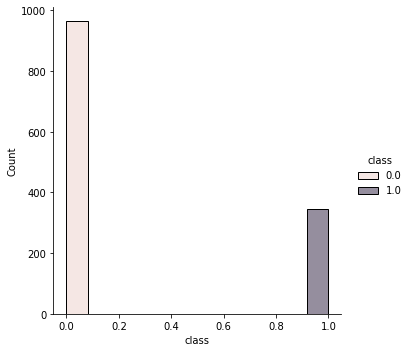

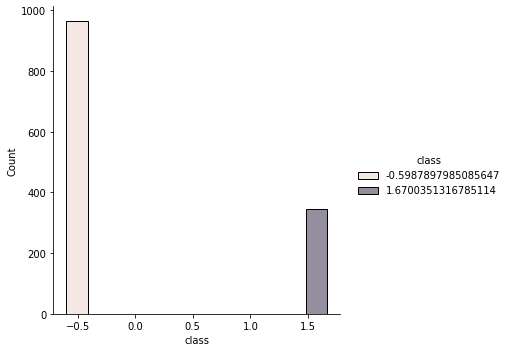

In [430]:
sns.displot(dfp, x='class', hue='class')
sns.displot(df, x='class', hue='class')

Povodny: 0.0002923945430666208
Transformovany 1.4039214549179276e-25
Povodny je blizsie k normalnemu rozdeleniu.


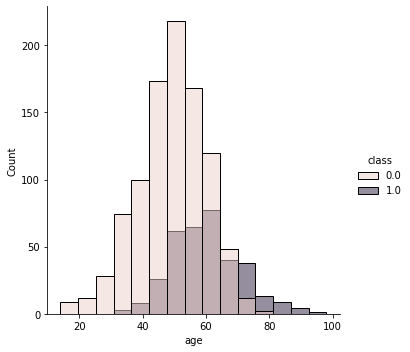

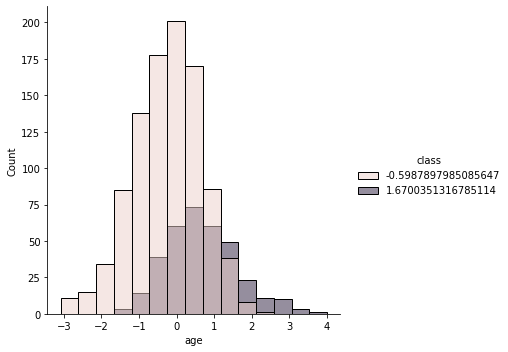

In [454]:
normality_check(dfp, df, 'age')
sns.displot(dfp, x='age', hue='class', bins = 15)
sns.displot(df, x='age', hue='class', bins = 15)

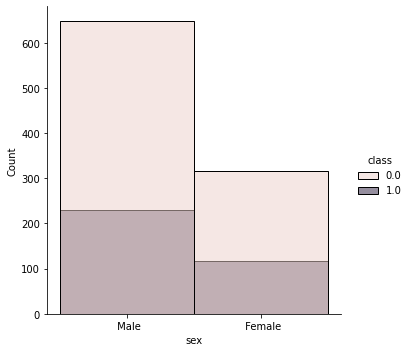

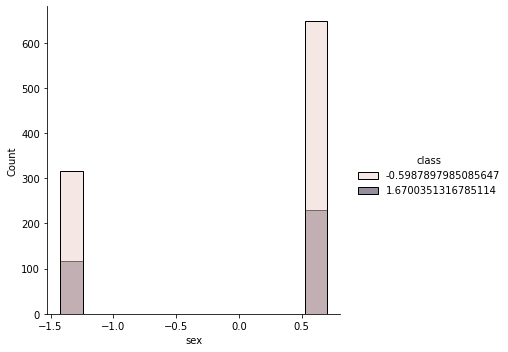

In [432]:
sns.displot(dfp, x='sex', hue='class')
sns.displot(df, x='sex', hue='class')

Povodny: 0.0
Transformovany 6.670582494588638e-30
Transformovany je blizsie k normalnemu rozdeleniu.


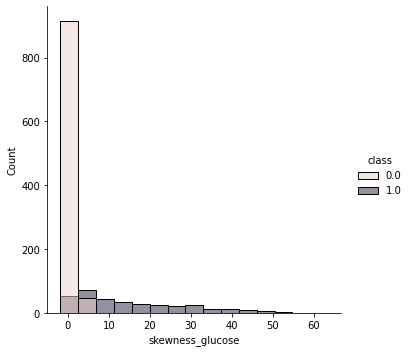

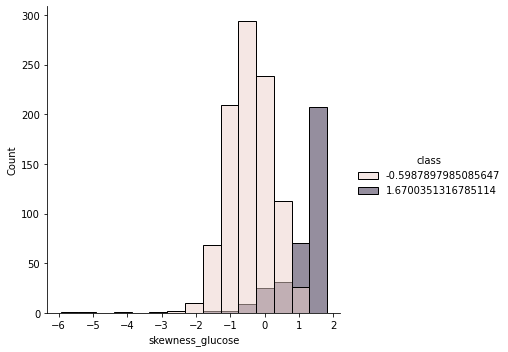

In [450]:
normality_check(dfp, df, 'skewness_glucose')
sns.displot(dfp, x='skewness_glucose', hue='class', bins = 15)
sns.displot(df, x='skewness_glucose', hue='class', bins = 15)

Povodny: 1.1641508497466152e-26
Transformovany 5.3030819561075576e-30
Povodny je blizsie k normalnemu rozdeleniu.


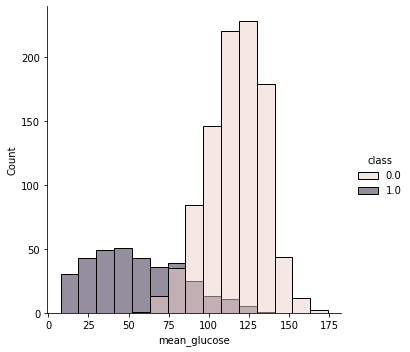

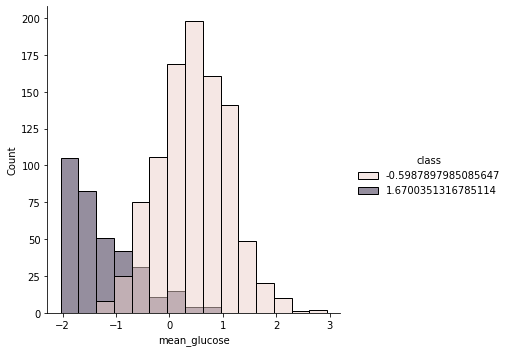

In [455]:
normality_check(dfp, df, 'mean_glucose')
sns.displot(dfp, x='mean_glucose', hue='class', bins = 15)
sns.displot(df, x='mean_glucose', hue='class', bins = 15)

Povodny: 3.2369994525903274e-43
Transformovany 8.983929045933442e-30
Transformovany je blizsie k normalnemu rozdeleniu.


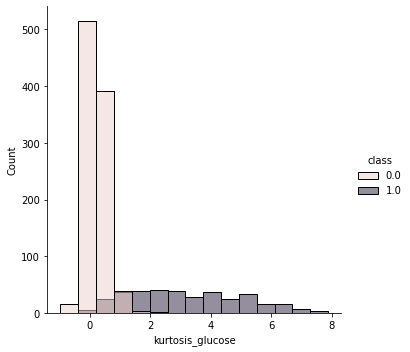

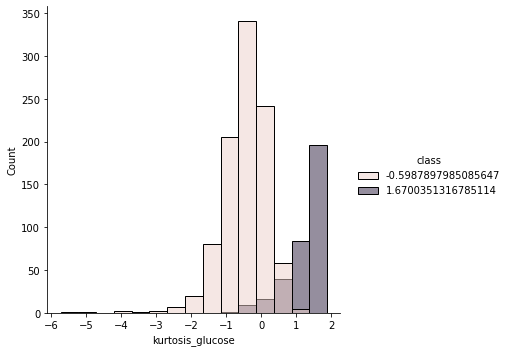

In [456]:
normality_check(dfp, df, 'kurtosis_glucose')
sns.displot(dfp, x='kurtosis_glucose', hue='class', bins = 15)
sns.displot(df, x='kurtosis_glucose', hue='class', bins = 15)

Povodny: 2.20623311286694e-11
Transformovany 3.022845347180128e-26
Povodny je blizsie k normalnemu rozdeleniu.


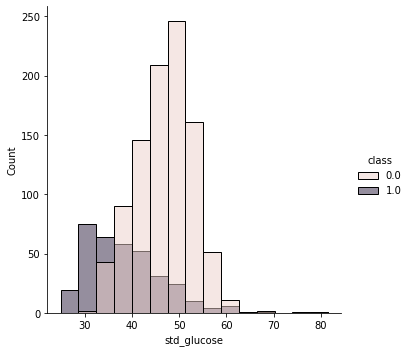

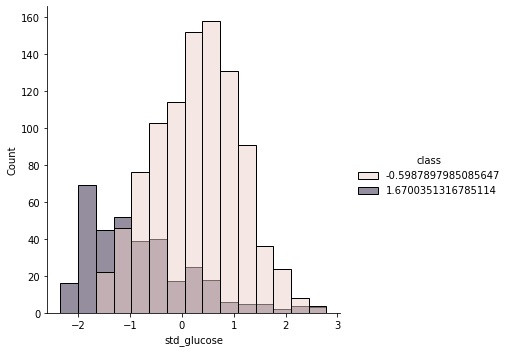

In [457]:
normality_check(dfp, df, 'std_glucose')
sns.displot(dfp, x='std_glucose', hue='class', bins = 15)
sns.displot(df, x='std_glucose', hue='class', bins = 15)

Povodny: 4.4778499361796954e-33
Transformovany 1.2940889303511483e-37
Povodny je blizsie k normalnemu rozdeleniu.


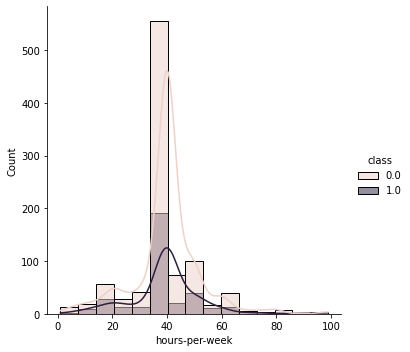

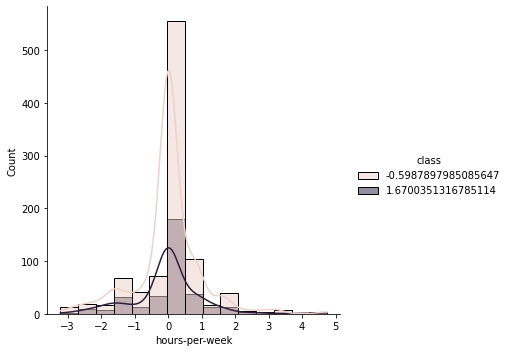

In [459]:
normality_check(dfp, df, 'hours-per-week')
sns.displot(dfp, x='hours-per-week', hue='class', bins = 15, kde=True)
sns.displot(df, x='hours-per-week', hue='class', bins = 15, kde=True)